### Beer Reviews Dataset

Please download the **[beer reviews](https://s3.amazonaws.com/demo-datasets/beer_reviews.tar.gz) dataset.**

# Recommending Beers: A Content-Based Recommendation System

### Objective

**To recommend beers based on similarity of user profile to item profile (content-based recommender system)**

### Steps

  1. Map items and users into a feature space
  1. Predicting ratings (or likes/dislikes) given the features
  
For this example, predictions of recommended or non-recommended items are calculated using either dot product and linear regression.
  
**Item Profile**
![](figs/itemprofile.png)

**User Profile**
![](figs/userprofile.png)

**Mapping User Profile (`u`) and Item Profile (`i`) in Feature Space**

![](figs/map.png)

***In this example, instead of using cosine similarity, we will be using dot product.***

![](figs/dotproduct.png)

***An alternate way of prediction shown here is by linear regression.***

### Loading code and data 

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from patsy import dmatrix
import seaborn.apionly as sb
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("../recommendersystems_wids_prep/beer_reviews/beer_reviews.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586614 non-null int64
brewery_name          1586599 non-null object
review_time           1586614 non-null int64
review_overall        1586614 non-null float64
review_aroma          1586614 non-null float64
review_appearance     1586614 non-null float64
review_profilename    1586266 non-null object
beer_style            1586614 non-null object
review_palate         1586614 non-null float64
review_taste          1586614 non-null float64
beer_name             1586614 non-null object
beer_abv              1518829 non-null float64
beer_beerid           1586614 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [4]:
print "We have {} reviews for {} beers from {} breweries, by {} drinkers.".format(len(data), 
                                                                                 data.beer_beerid.nunique(), 
                                                                                 data.brewery_id.nunique(), 
                                                                                 data.review_profilename.nunique())

We have 1586614 reviews for 66055 beers from 5840 breweries, by 33387 drinkers.


**Truncate data to speed up calculations:**

In [5]:
N = 150000
data = data.iloc[:N]
print "We have {} reviews for {} beers from {} breweries, by {} drinkers.".format(len(data), 
                                                                                  data.beer_beerid.nunique(), 
                                                                                  data.brewery_id.nunique(), 
                                                                                  data.review_profilename.nunique())

We have 150000 reviews for 6420 beers from 589 breweries, by 13964 drinkers.


In [6]:
data.head(3)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215


#### Data exploration

Let's see per features how many categories we have.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 13 columns):
brewery_id            150000 non-null int64
brewery_name          150000 non-null object
review_time           150000 non-null int64
review_overall        150000 non-null float64
review_aroma          150000 non-null float64
review_appearance     150000 non-null float64
review_profilename    149973 non-null object
beer_style            150000 non-null object
review_palate         150000 non-null float64
review_taste          150000 non-null float64
beer_name             150000 non-null object
beer_abv              144889 non-null float64
beer_beerid           150000 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 14.9+ MB


==> missing 'review_profilename' and 'beer_abv'

In [8]:
for col in data:
    print "{:20s}: {:7} uniques".format(col, data[col].nunique())

brewery_id          :     589 uniques
brewery_name        :     589 uniques
review_time         :  149904 uniques
review_overall      :      10 uniques
review_aroma        :       9 uniques
review_appearance   :      10 uniques
review_profilename  :   13964 uniques
beer_style          :     102 uniques
review_palate       :       9 uniques
review_taste        :       9 uniques
beer_name           :    6101 uniques
beer_abv            :     177 uniques
beer_beerid         :    6420 uniques


**USERS**

`review_profilename` (there are 13964 users or reviewers)

**ITEMS**

`beer_beerid`  (there are 6420 beers reviewed)

**FEATURES**

- `brewery_id` (or `brewery_name`)
- `beer_abv` (% alcohol)
- `beer_style`

**RATINGS**

- `review_overall` (10 uniques -- rating goes from 1 to 5 (ratings are 0, 1, 1.5, 2, 2.5, etc., see beer rating distribution below.)

*Other ratings can be used:*
- `review_aroma`
- `review_appearance`
- `review_palate`
- `review_taste`

Since the beer names are not unique, we will use the beer IDs. 

**Create lookup table from `beer_beerid` to `beer_name` (to easily track the beer's name):**

In [9]:
beer_names = data.groupby('beer_beerid').beer_name.first()  # only one name per ID

In [10]:
beer_names.head()

beer_beerid
3             Cactus Queen IPA
4     Wildcatter's Crude Stout
80         Organic Münster Alt
81             Organic Ur Pils
82         Organic Hefe-Weizen
Name: beer_name, dtype: object

**Distribution of beer rating:**

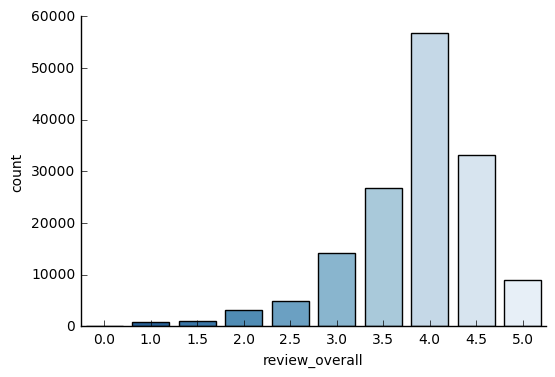

In [24]:
sb.countplot(data.review_overall, palette='Blues_r')
sb.despine();

Also note that the beer-drinker reviews are not unique, as some people have filed multiple reviews per beer.  We generally take the average rating in such case.

In [14]:
n_reviews = data.groupby(['beer_beerid', 'review_profilename']).review_overall.nunique()
n_reviews.value_counts()

1    147421
2       930
3        13
Name: review_overall, dtype: int64

### Create feature matrix (or item profile)

==> `beer_features` matrix

![](figs/beerprofile.png)

#### `beer_abv`

We will categorize the `beer_abv` feature into bins.

Currently, there are 177 unique values for `beer_abv`:

In [15]:
data.beer_abv.nunique()

177

To categorize the `beer_abv` values:

1. round off to whole values
2. bin values lower or equal to 4 to 4 and values greater than or equal to 10 to 10
3. leave values between 4 and 10 as is
4. convert values into strings (to prepare for patsy)

In [16]:
min_bin, max_bin = 4, 10
abv = data.beer_abv.round()

In [17]:
abv[abv <= min_bin] = min_bin

In [18]:
abv[abv >= max_bin] = max_bin

In [19]:
abv.unique()

array([  5.,   6.,   8.,   4.,   7.,  nan,   9.,  10.])

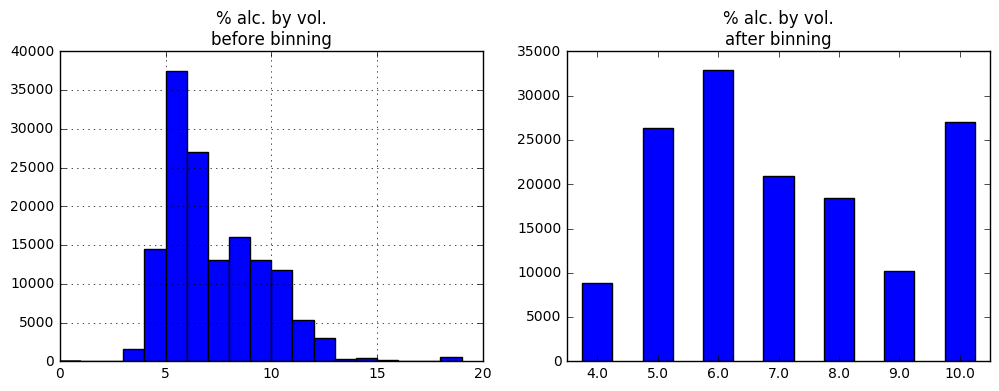

In [20]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
f = data.beer_abv.hist(bins=range(0, 20), ax=axes[0])
axes[0].set_title("% alc. by vol.\nbefore binning")
f = abv.value_counts().sort_index().plot(kind='bar', rot=0, ax=axes[1], title="% alc. by vol.\nafter binning")

We convert numerical values to strings, so patsy will treat them as categorical features

In [26]:
data['beer_abv_cat'] = abv.dropna().astype(int).astype(str)

**`brewery_id`**

In [27]:
data['brewery_id_str'] = data.brewery_id.astype(str)

**Use `dmatrix` to create a design matrix:**

To learn more about patsy.dmatrix, see http://patsy.readthedocs.io/en/latest/

In [28]:
X_abv_brew = dmatrix('beer_abv_cat + brewery_id_str', data=data.fillna(0), return_type='dataframe')

In [29]:
X_abv_brew.shape

(150000, 596)

In [30]:
X_abv_brew.head()

,Intercept,beer_abv_cat[T.10],beer_abv_cat[T.4],beer_abv_cat[T.5],beer_abv_cat[T.6],beer_abv_cat[T.7],beer_abv_cat[T.8],beer_abv_cat[T.9],brewery_id_str[T.10101],brewery_id_str[T.10103],...,brewery_id_str[T.9483],brewery_id_str[T.954],brewery_id_str[T.9608],brewery_id_str[T.9645],brewery_id_str[T.971],brewery_id_str[T.9729],brewery_id_str[T.9734],brewery_id_str[T.9816],brewery_id_str[T.9827],brewery_id_str[T.9932]
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**`beer_style`**

Let's use each word in the beer style as a feature as well (e.g., "IPA") using the 'bag-of-words' representation.

In [31]:
max_features = 5000
cv = CountVectorizer(max_features=max_features)
X_style = cv.fit_transform(data.beer_style)

In [32]:
X_style

<150000x120 sparse matrix of type '<type 'numpy.int64'>'
	with 416728 stored elements in Compressed Sparse Row format>

At this point we have:
- `beer_abv_cat` (7 features, in `X_abv_brew`)
- `beer_beerid_cat` (589 features, in `X_abv_brew`)
- `beer_style` (120 features, in `X_style` matrix)

==> a total of 716 features!

##### Putting all the features together to create the feature matrix (item profile)

In [36]:
X = np.hstack([X_abv_brew, X_style.toarray()])
y = data.review_overall
n_samples, n_features = X.shape

**Now, we have a feature matrix $X$ with ratings in $y$, containing both beers and drinkers.**

Since the features only describe beer characteristics, each beer entry in $X$ has the same values for the same beer. So we can just take a beer's first occurence for its representation.

In [37]:
uniques, idx = np.unique(data.beer_beerid, return_index=True)
beer_features = pd.DataFrame(X[idx, :], index=data.beer_beerid[idx])
print beer_features.shape
beer_features.head(2)

(6420, 716)


,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
beer_beerid,,,,,,,,,,,,,,,,,,,,,
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(Recall that we 6420 unique beers, see data exploration part above.)

**`beer_features` matrix is a sparse matrix composed of 1's and 0's with 6420 items and 716 features**

### Create user profile

==> `reviewer_features`

![](figs/beerreviewerprofile.png)

Note that the features for this matrix should be the same as the feature matrix.

**Steps:**

- Use feature matrix `X` created above and broadcast the reviewer ratings into it.

For example,

            low-abv  high-abv  IPA  Stout  Pilsner rating  reviewer
    beer 1     1        0       0     0       1     2.0    reviewer1
    beer 2     0        1       1     0       0     4.5    reviewer2
    
...will become...

            low-abv  high-abv  IPA  Stout  Pilsner  reviewer
    beer 1    2.0       0       0     0      2.0       reviewer1
    beer 2     0       4.5     4.5    0       0        reviewer2
    
- Average all ratings per user to get a user profile. Also, subtract 3 from each rating, so bad ratings are negative and good ratings are positive This is to compensate for all missing entries, which will automatically get a zero-rating (and are now rated as average, instead of terribly bad).

In [44]:
reviewer_features = pd.DataFrame(X * (data.review_overall.values - 3).reshape(n_samples, 1))

In [45]:
reviewer_features.head()

,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
0,-1.5,-0.0,-0.0,-1.5,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
reviewer_features['review_profilename'] = data.review_profilename

In [47]:
reviewer_features.head()

,0,1,2,3,4,5,6,7,8,9,...,707,708,709,710,711,712,713,714,715,review_profilename
0,-1.5,-0.0,-0.0,-1.5,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,stcules
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,stcules
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,stcules
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,stcules
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,johnmichaelsen


In [48]:
reviewer_features = reviewer_features.groupby('review_profilename')[range(n_features)].mean()

In [49]:
reviewer_features = reviewer_features.divide(reviewer_features.sum(axis=1), axis=0)

In [50]:
reviewer_features.head()

,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.168582,0.080460,0.0,0.000000,0.038314,0.022989,0.030651,-0.003831,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.011494,0.0,0.003831,0.0
05Harley,0.173554,0.074380,0.0,0.000000,0.024793,0.041322,0.016529,0.016529,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.008264,0.000000,0.0,0.000000,0.0
0tt0,0.196429,0.000000,0.0,0.035714,0.000000,0.107143,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
100floods,0.176056,0.084507,0.0,0.000000,0.021127,0.056338,0.014085,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
100proof,0.200000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


Now that we have `beer_features` and `reviewer_features`, we can proceed to calculating the distance or similarity between two vectors using dot product method.

![](figs/matrices.png)

### Predict recommendation by dot product

Let's pick an arbitrary user.

In [53]:
user = 'WesWes'

Compute user's vector and all beer vectors, and take dot product.

In [69]:
v = reviewer_features.loc[user].values

In [70]:
M = beer_features.values

In [71]:
pred = M.dot(v)

In [72]:
pred

array([ 0.28119382,  0.27076591,  0.20927724, ...,  0.29989213,
        0.30744337,  0.23696512])

In [73]:
pred = pd.Series(pred, index=beer_features.index, name="predictions").sort_values(ascending=False, inplace=False)

In [74]:
pred

beer_beerid
276      0.409924
8171     0.409924
27865    0.404890
73121    0.401654
8170     0.401654
12186    0.399137
31625    0.399137
42939    0.399137
30247    0.399137
74662    0.399137
21824    0.399137
75876    0.396620
51301    0.396620
53794    0.396620
4073     0.396620
52312    0.396620
34419    0.396620
67771    0.395901
7805     0.395901
1550     0.393384
34461    0.391945
3680     0.391586
1598     0.389788
54059    0.388709
75087    0.388709
64129    0.388709
72766    0.388350
74189    0.388350
16690    0.388350
66269    0.388350
           ...   
75480    0.174038
70983    0.174038
71003    0.174038
74149    0.174038
49607    0.174038
44800    0.174038
27824    0.174038
18509    0.174038
23234    0.174038
18576    0.174038
37103    0.174038
50849    0.174038
6440     0.174038
70786    0.174038
34648    0.174038
64391    0.174038
24370    0.174038
37680    0.174038
69410    0.174038
12395    0.174038
34650    0.174038
11713    0.174038
46666    0.174038
76127    0.17403

Change the beer id (the index) with beer names:

In [75]:
pred_name = pd.Series(pred.values, beer_names[pred.index], name=pred.name)

In [76]:
pred_name

beer_name
Sierra Nevada Pale Ale                                                    0.409924
Extra Special Pale Ale (ESP)                                              0.409924
Founders Brassworks Ale                                                   0.404890
Allocation Ale - Beer Camp #52                                            0.401654
Sierra Nevada Draught Style Pale Ale                                      0.401654
Founders Weizenbier                                                       0.399137
Founders Gold Sunshine                                                    0.399137
Founders Dumbo Head Wheat Beer                                            0.399137
Founders White Sunshine Weiss                                             0.399137
Founders Dry Hopped Honey Wheat                                           0.399137
Founders Hop Sun                                                          0.399137
Founders Boss Pale Ale                                                    0.3

In [77]:
print "Top recommendations for {}:".format(user)
print pred_name.head()

Top recommendations for WesWes:
beer_name
Sierra Nevada Pale Ale                  0.409924
Extra Special Pale Ale (ESP)            0.409924
Founders Brassworks Ale                 0.404890
Allocation Ale - Beer Camp #52          0.401654
Sierra Nevada Draught Style Pale Ale    0.401654
Name: predictions, dtype: float64


In [78]:
print "Bottom  recommendations (don't drink these, {}!)".format(user)
print pred_name.tail()

Bottom  recommendations (don't drink these, WesWes!)
beer_name
Europa Schwartz Pils         0.174038
Bald Eagle Kristallweizen    0.174038
Roggenbier                   0.174038
Zwickelbier                  0.174038
Replic Ale (2010)            0.174038
Name: predictions, dtype: float64


How do they compare with his actual reviews?  (Note that we take the mean since multiple reviews per drinker-beer pair occur.)

In [80]:
user_reviews = data[data.review_profilename == user].groupby('beer_beerid') \
                                                    .review_overall.mean() \
                                                    .sort_values(ascending=False, inplace=False)

In [81]:
user_reviews_name = pd.Series(user_reviews.values, index=beer_names[user_reviews.index])

In [82]:
print "Top reviewed by {}:".format(user)
print user_reviews_name.head()

Top reviewed by WesWes:
beer_name
Black Tuesday                              5.0
Founders KBS (Kentucky Breakfast Stout)    5.0
Northern Hemisphere Harvest Wet Hop Ale    5.0
Stoudt's Double IPA (India Pale Ale)       5.0
Founders CBS Imperial Stout                5.0
dtype: float64


In [83]:
print "Bottom reviewed by {}:".format(user)
print user_reviews_name.tail()

Bottom reviewed by WesWes:
beer_name
Weizen Berry                               3.0
Heineken Premium Light Lager               3.0
Pikop Andropov's Rushin' Imperial Stout    3.0
ESB Amber Ale                              3.0
Organic Münster Alt                        3.0
dtype: float64


Let's compare them all.

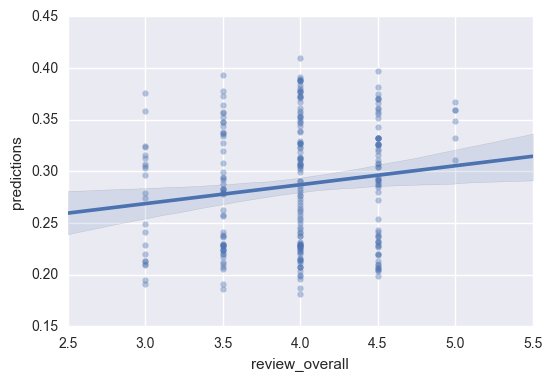

In [84]:
f = sb.regplot(user_reviews, pred[list(user_reviews.index)], scatter_kws=dict(alpha=.4))

Not bad. Note that we completely ignored overfitting and cross validation for readability's sake.

### Alternatively, predict recommendations using linear regression

Given this feature matrix and user reviews, we could also use a simple linear regression to predict a review for a user.  We will limit our dataset to the reviews of one user only, and then feed those into the model.

In [49]:
print "Filtering reviews by {}:".format(user)
idx = (data.review_profilename == user).values  # filter reviews of user
X_user, y_user = X[idx, :], y[idx]
print X_user.shape, y_user.shape

Filtering reviews by WesWes:
(253, 716) (253,)


In [50]:
model = Ridge()
model.fit(X_user, y_user)
print cross_val_score(model, X_user, y_user, scoring='neg_mean_absolute_error')
print cross_val_score(model, X_user, y_user, scoring='r2')

[-0.42260271 -0.39218923 -0.38307428]
[-0.22913789 -0.14327301  0.04404437]


Pretty bad cross-validation scores, but mind you we have only a handful reviews.

In [51]:
uniques, idx = np.unique(data.beer_beerid, return_index=True)  # find beer labels
pred = pd.Series(model.predict(X[idx, :]), index=data.beer_beerid[idx], name="predictions") \
    .sort_values(ascending=False, inplace=False)
pred_name = pd.Series(pred.values, beer_names[pred.index], name="predictions")
print "Top recommendations for {}.".format(user)
print pred_name[:5]

Top recommendations for WesWes.
beer_name
Sierra Nevada Imperial Stout                               4.796611
Able I.P.A.                                                4.790692
The Colonel's Porter                                       4.780963
The Colonel's Porter (Cask Primed With English Treacle)    4.780963
Samson                                                     4.752497
Name: predictions, dtype: float64


Let's see how those relate to his actual reviews.

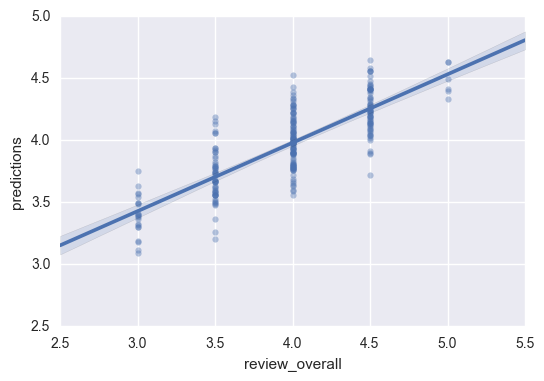

In [52]:
f = sb.regplot(user_reviews, pred[list(user_reviews.index)], scatter_kws=dict(alpha=.4))

Pretty spectacular. 

Just for the fun of it, how will this user rate a random beer?

In [53]:
beer = np.random.choice(beer_names.index)
beer_idx = (data.beer_beerid == beer).values
X_beer = X[beer_idx, :][0]  # just take the first entry
print "{} will give beer {} a rating of {:.1f}.".format(user, beer_names[beer], model.predict(X_beer.reshape(1,-1))[0])

WesWes will give beer D.O.R.I.S. The Destroyer Double Imperial Stout a rating of 4.2.
